# U-Net Segmentation

In [29]:
# Google Drive setup
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [30]:
import numpy as np
import cv2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import random
import os

def load_coco_dataset(data_dir, annotation_file):
    # Initialize COCO api for instance annotations
    coco = COCO(annotation_file)

    # Load categories
    cat_ids = coco.getCatIds()
    cats = coco.loadCats(cat_ids)
    cat_names = [cat['name'] for cat in cats]
    cat_name_to_id = {cat['name']: cat['id'] for cat in cats}
    # print(cat_name_to_id)

    # Load image ids
    img_ids = coco.getImgIds()
    # print(img_ids)

    images = []
    masks = []

    for img_id in img_ids:
        # Load image
        img_info = coco.loadImgs(img_id)[0]
        img_path = f"{data_dir}/{img_info['file_name']}"
        image = cv2.imread(img_path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Load annotations for the image
        ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anns = coco.loadAnns(ann_ids)

        masks_image = []
        for ann in anns:
            mask = generate_mask(ann['segmentation'][0], (img_info['height'], img_info['width']))
            masks_image.append(mask)

        final_image_mask = add_up_masks(masks_image, (img_info['height'], img_info['width']))
        images.append(image)
        masks.append(final_image_mask)

    return images, masks, cat_name_to_id

def add_up_masks(masks_image, image_shape):
  merged_mask = np.zeros(image_shape[:2], dtype=np.uint8)
  for mask in masks_image:
      merged_mask = cv2.add(merged_mask, mask)
  return merged_mask

def generate_mask(points, image_shape):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    pts = np.array(points, np.int32)
    pts = pts.reshape((-1, 2))
    cv2.fillPoly(mask, [pts], color=(255))

    return mask


In [31]:
data_dir = '/content/gdrive/MyDrive/cell_nuclei_data/COCO_cell_nuclei/images'
annotation_file = '/content/gdrive/MyDrive/cell_nuclei_data/COCO_cell_nuclei/trainval.json'
images, masks, cat_name_to_id = load_coco_dataset(data_dir, annotation_file)

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


## Checking image and corresponding mask

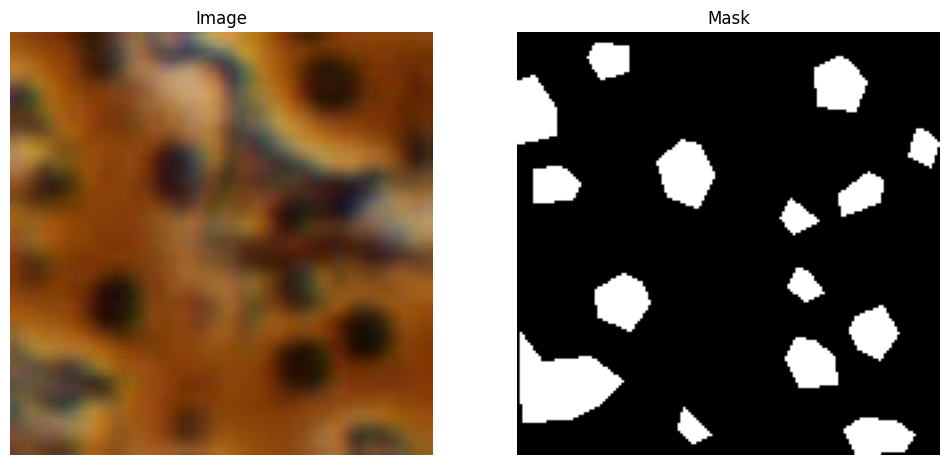

True


In [32]:
random_idx = random.randint(0, len(images)-1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(images[random_idx])
axes[0].set_title("Image")
axes[0].axis('off')
axes[1].imshow(masks[random_idx], cmap="gray")
axes[1].set_title("Mask")
axes[1].axis('off')
plt.show()

print(len(images) == len(masks))

## U-Net

Based on https://youtu.be/BNPW1mYbgS4 (U-Net model)


In [33]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
import keras
import numpy as np
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [34]:
def get_current_time_str():
  from datetime import datetime

  # Get current time
  now = datetime.now()

  # Some options:
  #  - "%Y-%m-%d %H:%M:%S"  # Year-Month-Day Hour:Minute:Second (e.g., 2024-04-04 15:49:23)
  #  - "%d/%m/%Y %H:%M:%S"  # Day/Month/Year Hour:Minute:Second (e.g., 04/04/2024 15:49:23)
  #  - "%H:%M:%S"          # Hour:Minute:Second (e.g., 15:49:23)
  time_string = now.strftime("%Y%m%d-%H:%M")

  return time_string


In [35]:
# If GPU is available, otherwise comment this section
from tensorflow.python.client import device_lib
import tensorflow as tf

print(device_lib.list_local_devices())
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(physical_devices))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2036519784125180541
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14699322303931818564
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Num GPUs Available: 1


Declaring own evaluation metric (Jaccard coefficient/IoU) and own loss function (-Jaccard coefficient)

In [36]:
@keras.saving.register_keras_serializable()
def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

@keras.saving.register_keras_serializable()
def jaccard_coef_loss(y_true, y_pred):
    return -jaccard_coef(y_true, y_pred)  # -1 multiplied as we want to minimize this value as loss function

### U-Net declaration

In [37]:
def unet_model_with_jaccard(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    conv1 = Dropout(0.1)(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.1)(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    u6 = concatenate([u6, conv4])
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up7)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)

    up8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up8)
    conv8 = Dropout(0.1)(conv8)
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)

    up9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up9)
    conv9 = Dropout(0.1)(conv9)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer = 'adam', loss = [jaccard_coef_loss], metrics = [jaccard_coef])

    model.summary()

    return model

In [38]:
# Load train images and masks here
train_images = images
train_masks = masks

# Preprocess your data as needed (e.g., normalization, resizing)
def preprocess_images(image_list, new_size):
    preprocessed_images = []
    for img in image_list:
        # Resize image
        resized_img = cv2.resize(img, new_size)

        # Normalize pixel values to the range [0, 1]
        normalized_img = resized_img.astype(np.float64) / 255
        preprocessed_images.append(normalized_img)

    return preprocessed_images

train_images = preprocess_images(train_images, (256, 256))
train_masks = preprocess_images(train_masks, (256, 256))
train_masks = np.expand_dims(train_masks, axis=-1)

# Stack the lists of arrays into single arrays with an additional dimension
train_images_stacked = np.stack(train_images)
train_masks_stacked = np.stack(train_masks)

# print(type(train_masks_stacked[0]))
# print(type(train_images_stacked[0]))

# print(train_masks_stacked[0].dtype)
# print(train_images_stacked[0].dtype)

# print(train_masks_stacked[0])
# print(train_images_stacked[0])

# Checking images and masks shape
print(train_images_stacked.shape)
print(train_masks_stacked.shape)

(100, 256, 256, 3)
(100, 256, 256, 1)


Preparing dataset

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images_stacked, train_masks_stacked, test_size = 0.10, random_state = 0)

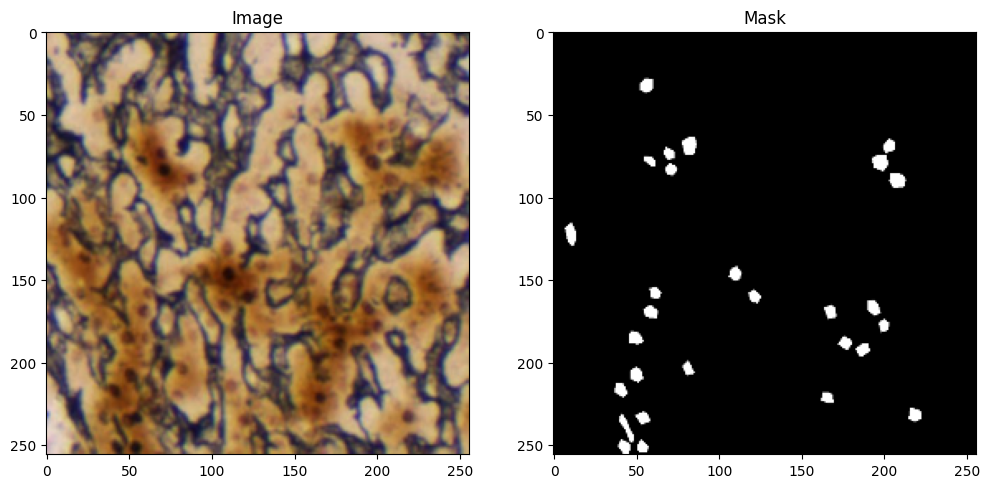

In [40]:
import random
import numpy as np
image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Image")
plt.imshow(X_train[image_number])
plt.subplot(122)
plt.title("Mask")
plt.imshow(y_train[image_number], cmap='gray')
plt.show()

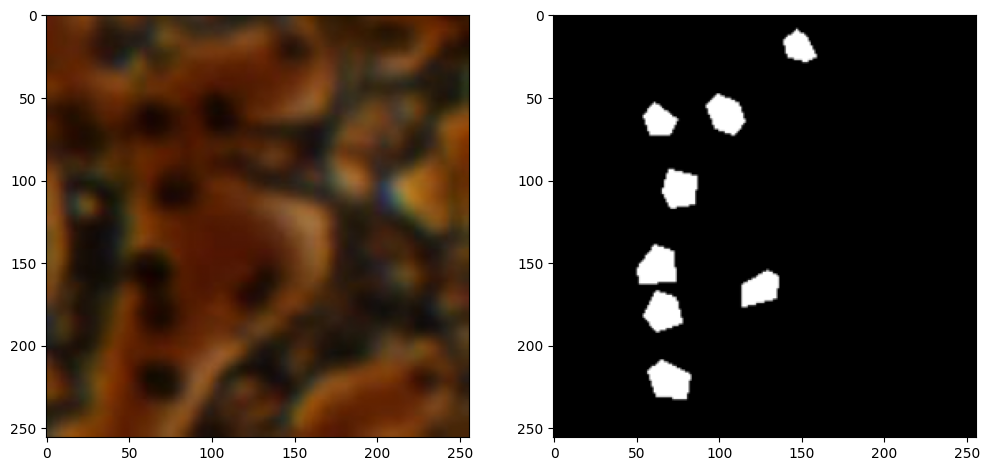

In [41]:
image_number = random.randint(0, len(X_test)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number])
plt.subplot(122)
plt.imshow(y_test[image_number], cmap='gray')
plt.show()

In [42]:
# Getting input parameters for U-Net
IMG_HEIGHT = train_images_stacked.shape[1]
IMG_WIDTH  = train_images_stacked.shape[2]
IMG_CHANNELS = train_images_stacked.shape[3]
print(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

256 256 3


In [43]:
# Getting Jaccard model
def get_jaccard_model():
    return unet_model_with_jaccard(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model_jaccard = get_jaccard_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 16)         448       ['input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 256, 256, 16)         0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 16)         2320      ['dropout_9[0][0]']           
                                                                                            

In [44]:
import pandas as pd

# Assuming model_jaccard is your compiled U-Net model

table = pd.DataFrame(columns=["Name", "Type", "Shape"])
for layer in model_jaccard.layers:
  # Create a dictionary for each layer
  layer_info = {"Name": layer.name, "Type": layer.__class__.__name__, "Shape": layer.output_shape}
  # Concatenate the dictionary as a new row to the DataFrame
  table = pd.concat([table, pd.DataFrame([layer_info])], ignore_index=True)

# Print the DataFrame with layer information
print(table.to_latex())

\begin{tabular}{llll}
\toprule
 & Name & Type & Shape \\
\midrule
0 & input_2 & InputLayer & [(None, 256, 256, 3)] \\
1 & conv2d_19 & Conv2D & (None, 256, 256, 16) \\
2 & dropout_9 & Dropout & (None, 256, 256, 16) \\
3 & conv2d_20 & Conv2D & (None, 256, 256, 16) \\
4 & max_pooling2d_4 & MaxPooling2D & (None, 128, 128, 16) \\
5 & conv2d_21 & Conv2D & (None, 128, 128, 32) \\
6 & dropout_10 & Dropout & (None, 128, 128, 32) \\
7 & conv2d_22 & Conv2D & (None, 128, 128, 32) \\
8 & max_pooling2d_5 & MaxPooling2D & (None, 64, 64, 32) \\
9 & conv2d_23 & Conv2D & (None, 64, 64, 64) \\
10 & dropout_11 & Dropout & (None, 64, 64, 64) \\
11 & conv2d_24 & Conv2D & (None, 64, 64, 64) \\
12 & max_pooling2d_6 & MaxPooling2D & (None, 32, 32, 64) \\
13 & conv2d_25 & Conv2D & (None, 32, 32, 128) \\
14 & dropout_12 & Dropout & (None, 32, 32, 128) \\
15 & conv2d_26 & Conv2D & (None, 32, 32, 128) \\
16 & max_pooling2d_7 & MaxPooling2D & (None, 16, 16, 128) \\
17 & conv2d_27 & Conv2D & (None, 16, 16, 256) \\
1

### Model training

In [45]:
NUM_EPOCHS = 50
BATCH_SIZE = 10

history_jaccard = model_jaccard.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    epochs=NUM_EPOCHS,
                    validation_data=(X_test, y_test),
                    shuffle=True)

Epoch 1/50
9/9 [==============================] - 8s 205ms/step - loss: -0.1065 - jaccard_coef: 0.1065 - val_loss: -0.1287 - val_jaccard_coef: 0.1287
Epoch 2/50
9/9 [==============================] - 1s 123ms/step - loss: -0.2132 - jaccard_coef: 0.2132 - val_loss: -0.3399 - val_jaccard_coef: 0.3399
Epoch 3/50
9/9 [==============================] - 1s 125ms/step - loss: -0.3079 - jaccard_coef: 0.3079 - val_loss: -0.3620 - val_jaccard_coef: 0.3620
Epoch 4/50
9/9 [==============================] - 1s 116ms/step - loss: -0.3310 - jaccard_coef: 0.3310 - val_loss: -0.3934 - val_jaccard_coef: 0.3934
Epoch 5/50
9/9 [==============================] - 1s 118ms/step - loss: -0.3757 - jaccard_coef: 0.3757 - val_loss: -0.4126 - val_jaccard_coef: 0.4126
Epoch 6/50
9/9 [==============================] - 1s 117ms/step - loss: -0.4010 - jaccard_coef: 0.4010 - val_loss: -0.4827 - val_jaccard_coef: 0.4827
Epoch 7/50
9/9 [==============================] - 1s 121ms/step - loss: -0.3766 - jaccard_coef: 0.37

In [46]:
history_jaccard.history.keys()

dict_keys(['loss', 'jaccard_coef', 'val_loss', 'val_jaccard_coef'])

In [47]:
# Saving model
model_name = get_current_time_str() + '_unet_cell_nuclei_' + str(NUM_EPOCHS) + 'epochs.keras'
model_output_path = '/content/gdrive/MyDrive/cell_nuclei_data/output/unet/' + model_name
# print(os.path.exists(model_output_path))

model_jaccard.save(model_output_path)

In [48]:
# Saving model
model_name = get_current_time_str() + '_unet_cell_nuclei_' + str(NUM_EPOCHS) + 'epochs.h5'
model_output_path = '/content/gdrive/MyDrive/cell_nuclei_data/output/unet/' + model_name
# print(os.path.exists(model_output_path))

model_jaccard.save(model_output_path, save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
loss_values = history_jaccard.history['loss']
jaccard_coeff_values = history_jaccard.history['jaccard_coef']
val_loss_values = history_jaccard.history['val_loss']
val_jaccard_coeff_values = history_jaccard.history['val_jaccard_coef']

### Visualizing results

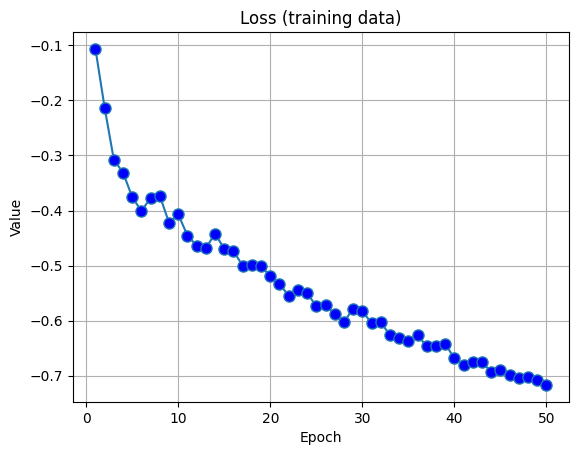

In [50]:
# Epochs (assuming they start from 1)
epochs = range(1, len(loss_values) + 1)  # Creates a sequence from 1 to the number of loss values

# Plot the loss values vs epochs
plt.plot(epochs, loss_values, '-o', markersize=8, markerfacecolor='blue')

plt.title("Loss (training data)")
plt.xlabel("Epoch")
plt.ylabel("Value")

plt.grid(True)
plt.show()

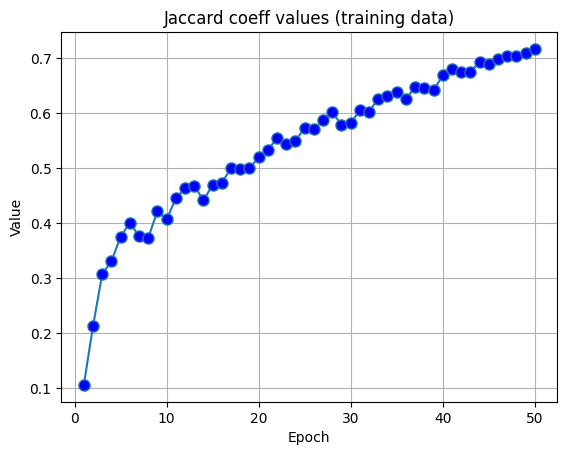

In [51]:
# Epochs (assuming they start from 1)
epochs = range(1, len(jaccard_coeff_values) + 1)  # Creates a sequence from 1 to the number of loss values

# Plot the Jaccard coeff values vs epochs
plt.plot(epochs, jaccard_coeff_values, '-o', markersize=8, markerfacecolor='blue')

plt.title("Jaccard coeff values (training data)")
plt.xlabel("Epoch")
plt.ylabel("Value")

plt.grid(True)
plt.show()

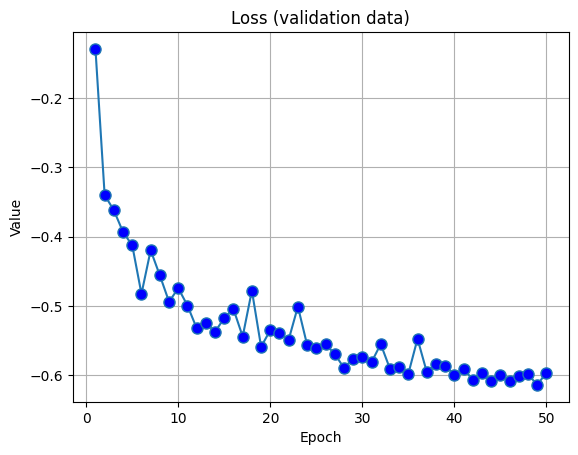

In [52]:
# Epochs (assuming they start from 1)
epochs = range(1, len(val_loss_values) + 1)  # Creates a sequence from 1 to the number of loss values

# Plot the loss values vs epochs
plt.plot(epochs, val_loss_values, '-o', markersize=8, markerfacecolor='blue')

plt.title("Loss (validation data)")
plt.xlabel("Epoch")
plt.ylabel("Value")

plt.grid(True)
plt.show()

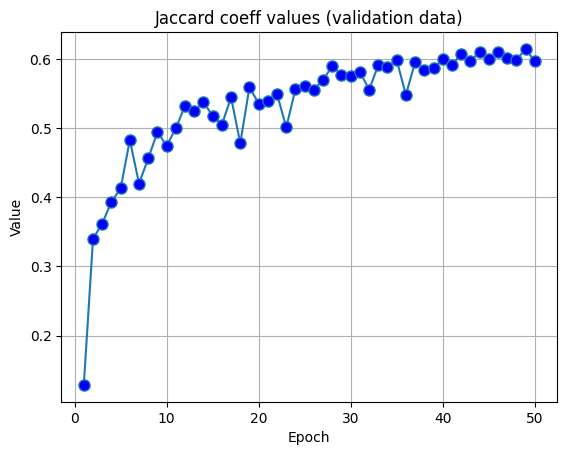

In [53]:
# Epochs (assuming they start from 1)
epochs = range(1, len(val_jaccard_coeff_values) + 1)  # Creates a sequence from 1 to the number of loss values

# Plot the Jaccard coeff values vs epochs
plt.plot(epochs, val_jaccard_coeff_values, '-o', markersize=8, markerfacecolor='blue')

plt.title("Jaccard coeff values (validation data)")
plt.xlabel("Epoch")
plt.ylabel("Value")

# Show the plot
plt.grid(True)
plt.show()

## Trying inference

In [54]:
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

my_model = load_model(model_output_path)

In [64]:
img_path = '/content/gdrive/MyDrive/cell_nuclei_data/COCO_cell_nuclei/images/J7_25_a_ann0016.jpg'
img = load_img(img_path, target_size=(my_model.input_shape[1:3]))  # Match model input size
x = img_to_array(img)
x = x / 255.0  # Assuming model expects normalized values (0-1)
x = np.expand_dims(x, axis=0)

# Get segmentation mask
mask = my_model.predict(x)

1/1 [==============================] - 0s 23ms/step


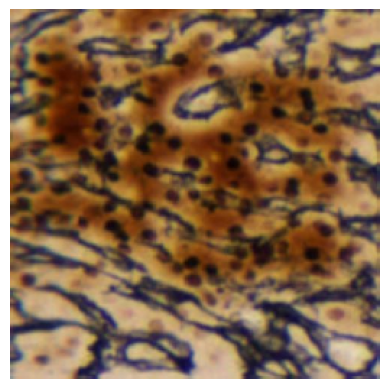

In [66]:
plt.imshow(img)
plt.axis("off")
plt.show()

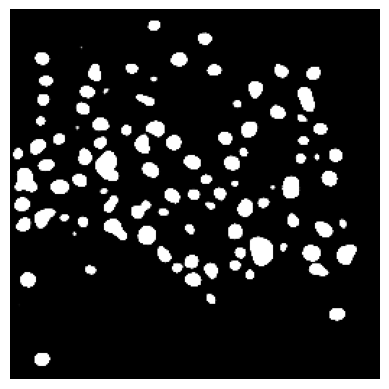

In [65]:
mask = np.squeeze(mask, axis=0)
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.show()